In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd
import scvi

Global seed set to 0


In [2]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


In [3]:
%load_ext autoreload
%autoreload 2

# Read data

In [4]:
# adt.h5ad is full dataset, change to adt_test.h5ad for a smaller subset
adt = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/stephenson-2021/stephenson2021_adt_test.h5ad')
adt

AnnData object with n_obs × n_vars = 10000 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [5]:
# rna.h5ad is full dataset, change to rna_test.h5ad for a smaller subset
rna = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/stephenson-2021/stephenson2021_rna_hvg_test.h5ad')
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [6]:
idx = adt.obs['patient_id'].sort_values().index # need to sort by patient for the data loader

In [7]:
adt = adt[idx].copy()
rna = rna[idx].copy()

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# MIL

In [8]:
# arange modality adatas into one adata
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],
    groups = [[0], [0]],
    layers = [['count'], [None]],
)
adata

AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [9]:
adata.obs['Status_on_day_collection_summary'].cat.categories

Index(['Healthy', 'Moderate'], dtype='object')

Include the columns that you want to predict on here too, i.e. if you want to classify on 'Status_on_day_collection_summary', include it as a categorical covariate.

Since we rather have an ordinal scale, we will do orginal regression instead of clasification.

If you have any covariates on ordinal scale, e.g. desease severity, that you later want to use either as a covariate or do ordinal regression on, specify it in `setup_anndata` with e.g.
```
ordinal_regression_order = {'severity': ['mild', 'severe']}
```

In [10]:
mtg.model.MultiVAE_MIL.setup_anndata(
            adata, 
            rna_indices_end=4000, # need to specify to calculate size_factor for NB loss
            categorical_covariate_keys=['Sex', 'Status_on_day_collection_summary', 'patient_id'],
            continuous_covariate_keys=['Age'],
            ordinal_regression_order={'Status_on_day_collection_summary': ['Healthy', 'Moderate']}
        )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10000 cells, 4192 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Next, we set up the model. If you want to predict continuous values, i.e. you have a regression task, specify it `regression` parameter, if you do classification -- in `classification`.

In [11]:
mil = mtg.model.MultiVAE_MIL(
            adata, 
            modality_lengths=[4000, 192],
            losses=['nb', 'mse'],
            loss_coefs={'kl': 5e-5, 'integ': 0},
            ordinal_regression=['Status_on_day_collection_summary'],
            patient_label='patient_id',
            scoring='gated_attn', # or 'attn', or 'MLP'
            n_layers_encoders=[1, 1] # how many layer for each modality encoder
        )

The order for Status_on_day_collection_summary ordinal classes is: Index(['Healthy', 'Moderate'], dtype='object'). If you need to change the order, please rerun setup_anndata and specify the correct order with "ordinal_regression_order" parameter.


In [12]:
mil.train(
    max_epochs=50, 
    batch_size=512,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Epoch 1/50:   2%|▏         | 1/50 [00:00<00:20,  2.39it/s, loss=2.45e+03, v_num=1]

Metric elbo_validation improved. New best score: 2212.229


Epoch 2/50:   4%|▍         | 2/50 [00:00<00:19,  2.46it/s, loss=2.32e+03, v_num=1]

Metric elbo_validation improved by 165.622 >= min_delta = 0.0. New best score: 2046.607


Epoch 3/50:   6%|▌         | 3/50 [00:01<00:19,  2.46it/s, loss=2.18e+03, v_num=1]

Metric elbo_validation improved by 109.080 >= min_delta = 0.0. New best score: 1937.526


Epoch 4/50:   8%|▊         | 4/50 [00:01<00:18,  2.52it/s, loss=2.01e+03, v_num=1]

Metric elbo_validation improved by 135.304 >= min_delta = 0.0. New best score: 1802.222


Epoch 5/50:  10%|█         | 5/50 [00:01<00:17,  2.56it/s, loss=1.89e+03, v_num=1]

Metric elbo_validation improved by 133.428 >= min_delta = 0.0. New best score: 1668.794


Epoch 6/50:  12%|█▏        | 6/50 [00:02<00:17,  2.58it/s, loss=1.79e+03, v_num=1]

Metric elbo_validation improved by 77.960 >= min_delta = 0.0. New best score: 1590.834


Epoch 7/50:  14%|█▍        | 7/50 [00:02<00:16,  2.56it/s, loss=1.69e+03, v_num=1]

Metric elbo_validation improved by 107.706 >= min_delta = 0.0. New best score: 1483.129


Epoch 8/50:  16%|█▌        | 8/50 [00:03<00:16,  2.57it/s, loss=1.57e+03, v_num=1]

Metric elbo_validation improved by 93.743 >= min_delta = 0.0. New best score: 1389.386


Epoch 9/50:  18%|█▊        | 9/50 [00:03<00:15,  2.59it/s, loss=1.48e+03, v_num=1]

Metric elbo_validation improved by 94.492 >= min_delta = 0.0. New best score: 1294.893


Epoch 10/50:  20%|██        | 10/50 [00:03<00:15,  2.60it/s, loss=1.4e+03, v_num=1] 

Metric elbo_validation improved by 52.995 >= min_delta = 0.0. New best score: 1241.898


Epoch 11/50:  22%|██▏       | 11/50 [00:04<00:14,  2.61it/s, loss=1.33e+03, v_num=1]

Metric elbo_validation improved by 68.423 >= min_delta = 0.0. New best score: 1173.476


Epoch 12/50:  24%|██▍       | 12/50 [00:04<00:14,  2.61it/s, loss=1.26e+03, v_num=1]

Metric elbo_validation improved by 47.581 >= min_delta = 0.0. New best score: 1125.895


Epoch 13/50:  26%|██▌       | 13/50 [00:05<00:14,  2.62it/s, loss=1.22e+03, v_num=1]

Metric elbo_validation improved by 51.712 >= min_delta = 0.0. New best score: 1074.182


Epoch 14/50:  28%|██▊       | 14/50 [00:05<00:13,  2.62it/s, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 32.872 >= min_delta = 0.0. New best score: 1041.310


Epoch 15/50:  30%|███       | 15/50 [00:05<00:13,  2.62it/s, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 73.283 >= min_delta = 0.0. New best score: 968.027


Epoch 16/50:  32%|███▏      | 16/50 [00:06<00:12,  2.62it/s, loss=1.07e+03, v_num=1]

Metric elbo_validation improved by 17.171 >= min_delta = 0.0. New best score: 950.857


Epoch 17/50:  34%|███▍      | 17/50 [00:06<00:12,  2.62it/s, loss=1.03e+03, v_num=1]

Metric elbo_validation improved by 25.908 >= min_delta = 0.0. New best score: 924.949


Epoch 18/50:  36%|███▌      | 18/50 [00:06<00:12,  2.62it/s, loss=1.01e+03, v_num=1]

Metric elbo_validation improved by 31.135 >= min_delta = 0.0. New best score: 893.814


Epoch 19/50:  38%|███▊      | 19/50 [00:07<00:11,  2.63it/s, loss=982, v_num=1]     

Metric elbo_validation improved by 17.458 >= min_delta = 0.0. New best score: 876.356


Epoch 20/50:  40%|████      | 20/50 [00:07<00:11,  2.63it/s, loss=956, v_num=1]

Metric elbo_validation improved by 8.403 >= min_delta = 0.0. New best score: 867.954


Epoch 21/50:  42%|████▏     | 21/50 [00:08<00:11,  2.62it/s, loss=930, v_num=1]

Metric elbo_validation improved by 20.412 >= min_delta = 0.0. New best score: 847.542


Epoch 22/50:  44%|████▍     | 22/50 [00:08<00:10,  2.62it/s, loss=917, v_num=1]

Metric elbo_validation improved by 7.084 >= min_delta = 0.0. New best score: 840.457


Epoch 23/50:  46%|████▌     | 23/50 [00:08<00:10,  2.62it/s, loss=894, v_num=1]

Metric elbo_validation improved by 16.886 >= min_delta = 0.0. New best score: 823.571


Epoch 24/50:  48%|████▊     | 24/50 [00:09<00:09,  2.62it/s, loss=878, v_num=1]

Metric elbo_validation improved by 21.596 >= min_delta = 0.0. New best score: 801.975


Epoch 26/50:  52%|█████▏    | 26/50 [00:10<00:09,  2.62it/s, loss=854, v_num=1]

Metric elbo_validation improved by 17.918 >= min_delta = 0.0. New best score: 784.057


Epoch 27/50:  54%|█████▍    | 27/50 [00:10<00:08,  2.62it/s, loss=848, v_num=1]

Metric elbo_validation improved by 5.124 >= min_delta = 0.0. New best score: 778.933


Epoch 28/50:  56%|█████▌    | 28/50 [00:10<00:08,  2.62it/s, loss=832, v_num=1]

Metric elbo_validation improved by 32.904 >= min_delta = 0.0. New best score: 746.029


Epoch 30/50:  60%|██████    | 30/50 [00:11<00:07,  2.63it/s, loss=820, v_num=1]

Metric elbo_validation improved by 2.923 >= min_delta = 0.0. New best score: 743.106


Epoch 33/50:  66%|██████▌   | 33/50 [00:12<00:06,  2.64it/s, loss=794, v_num=1]

Metric elbo_validation improved by 4.367 >= min_delta = 0.0. New best score: 738.738


Epoch 34/50:  68%|██████▊   | 34/50 [00:13<00:06,  2.62it/s, loss=791, v_num=1]

Metric elbo_validation improved by 3.916 >= min_delta = 0.0. New best score: 734.822


Epoch 35/50:  70%|███████   | 35/50 [00:13<00:05,  2.62it/s, loss=781, v_num=1]

Metric elbo_validation improved by 17.533 >= min_delta = 0.0. New best score: 717.289


Epoch 36/50:  72%|███████▏  | 36/50 [00:13<00:05,  2.62it/s, loss=786, v_num=1]

Metric elbo_validation improved by 1.642 >= min_delta = 0.0. New best score: 715.647


Epoch 37/50:  74%|███████▍  | 37/50 [00:14<00:04,  2.63it/s, loss=780, v_num=1]

Metric elbo_validation improved by 2.726 >= min_delta = 0.0. New best score: 712.921


Epoch 40/50:  80%|████████  | 40/50 [00:15<00:03,  2.60it/s, loss=761, v_num=1]

Metric elbo_validation improved by 3.942 >= min_delta = 0.0. New best score: 708.979


Epoch 41/50:  82%|████████▏ | 41/50 [00:15<00:03,  2.59it/s, loss=760, v_num=1]

Metric elbo_validation improved by 9.605 >= min_delta = 0.0. New best score: 699.374


Epoch 42/50:  84%|████████▍ | 42/50 [00:16<00:03,  2.60it/s, loss=758, v_num=1]

Metric elbo_validation improved by 1.561 >= min_delta = 0.0. New best score: 697.813


Epoch 43/50:  86%|████████▌ | 43/50 [00:16<00:02,  2.59it/s, loss=754, v_num=1]

Metric elbo_validation improved by 0.344 >= min_delta = 0.0. New best score: 697.469


Epoch 44/50:  88%|████████▊ | 44/50 [00:16<00:02,  2.60it/s, loss=751, v_num=1]

Metric elbo_validation improved by 8.265 >= min_delta = 0.0. New best score: 689.204


Epoch 46/50:  92%|█████████▏| 46/50 [00:17<00:01,  2.61it/s, loss=743, v_num=1]

Metric elbo_validation improved by 8.085 >= min_delta = 0.0. New best score: 681.118


Epoch 48/50:  96%|█████████▌| 48/50 [00:18<00:00,  2.63it/s, loss=738, v_num=1]

Metric elbo_validation improved by 3.647 >= min_delta = 0.0. New best score: 677.472


Epoch 49/50:  98%|█████████▊| 49/50 [00:18<00:00,  2.62it/s, loss=737, v_num=1]

Metric elbo_validation improved by 1.019 >= min_delta = 0.0. New best score: 676.452


Epoch 50/50: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss=740, v_num=1]


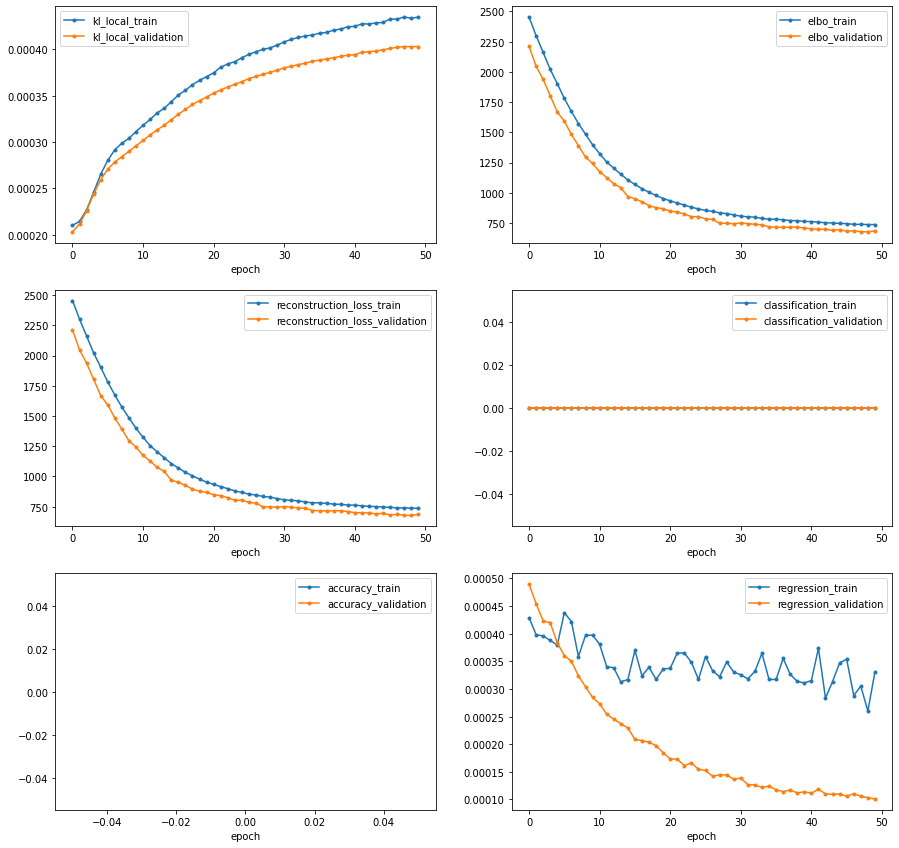

In [13]:
df = pd.DataFrame(mil.history['train_loss_step'])
for key in mil.history.keys():
    if key != 'train_loss_step':
        df = df.join(mil.history[key])

df['epoch'] = df.index

plt.figure(figsize=(15, 20))
loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'classification', 'accuracy', 'regression']
nrows = 4

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+1)
    plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
    plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')
    plt.xlabel('epoch')
    plt.legend()

# Inference

In [14]:
mil.get_model_output(batch_size=512)
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'bag_ordinal_true', 'bag_ordinal_predictions'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'cov_attn', 'ordinal_predictions'
    layers: 'count'

In [15]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

... storing 'feature_types' as categorical
... storing 'highly_variable' as categorical


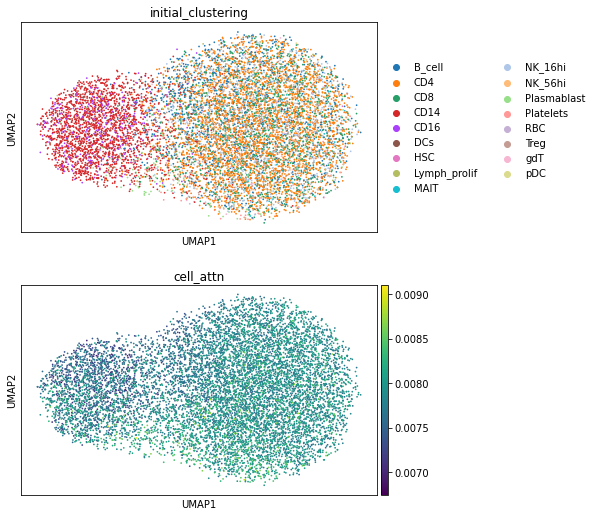

In [16]:
sc.pl.umap(adata, color=['initial_clustering', 'cell_attn'], ncols=1)

In [17]:
adata.obsm['cov_attn'].shape

(10000, 3)

In [18]:
adata.obs['molecular_attn'] = adata.obsm['cov_attn'][:, 0]
adata.obs['sex_attn'] = adata.obsm['cov_attn'][:, 1]
adata.obs['age_attn'] = adata.obsm['cov_attn'][:, 2]

In [19]:
adata

AnnData object with n_obs × n_vars = 10000 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn', 'molecular_attn', 'sex_attn', 'age_attn'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'bag_ordinal_true', 'bag_ordinal_predictions', 'neighbors', 'umap', 'initial_clustering_colors'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'cov_attn', 'ordinal_predictions', 'X_umap'
    layers: 'count'
    obsp: 'distances', 'connectivities'

An exmaple of what you can look at

<AxesSubplot:>

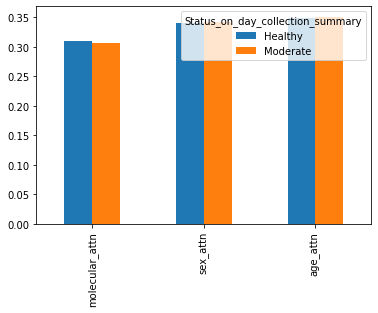

In [20]:
aggr = {
    'molecular_attn': 'mean',
    'sex_attn': 'mean',
    'age_attn': 'mean',
    'Status_on_day_collection_summary': 'first',
    'Age': 'first',
    'Sex': 'first'
    }

df = adata.obs[['molecular_attn', 'sex_attn', 'age_attn', 'Status_on_day_collection_summary', 'Age','Sex', 'patient_id']].groupby(['patient_id']).agg(aggr)

df = df[['molecular_attn', 'sex_attn', 'age_attn', 'Status_on_day_collection_summary']].groupby('Status_on_day_collection_summary').mean().transpose()
# df = df[['Healthy', 'Asymptomatic', 'Mild', 'Moderate', 'Severe', 'Critical']]
df.plot.bar()